In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")
#sns.set_context("poster")


In [2]:
# For this exercise you need to install yellowbrick
# it will be also useful to take a look at the documentation
#    scikit-yb.org
#
# ! pip install yellowbrick

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn import preprocessing

from sklearn.datasets import load_wine
from sklearn.datasets import load_boston

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.model_selection import LearningCurve


<h1>Clustering</h1>

Clustering is the most common and well-known unsupervised learning techniques. We can find clustring almost everywhere, in political campaigns, in client segmentation, ... The aglomeration of similar items is very familiar to us, Cities are clusters of people and in cities business traditionally cluster.

However, the fact that clustering is unsupervised poses some problems to validation metrics and verification. There is normally no grown truth, therefore there is not a single solution. Many times clusters, including its number, depends on the point of view of the problem and the questions that we are trying to address. 

The first problem that we encounter with clustering is finding out the best number of clusters. For this the elbow method is commonly used. It performs k-means with an increasingly number of clusters finding the k (number of clusters) that minimizes intra-cluster distance.

Checking the goodness is commonly done using the Silhoutte coefficient that measures the mean intra-cluster distance relative to the nearest clusters providing an appreciation of compactness. 

Clustering is very intuitive in two-dimensional spaces, but difficult to imagine in multidimensional spaces. The output of a clustering algorithm are centroids which consists of vectors with the center for each attribute. Using predict we can easily assign membership. 

Also we aware that clustering works measuring distances, therefore we need to rescaled (normally between 0..1) all the attributes. 

In this notebook we will use the UCI wine dataset, a compilation of characteristics of 178 Italian red wines divided in three families. We will see how well clustering can find without any example these three classes. 

In many cases, like this one, clustering has some coincidences with classification. This is precisely this case. When this happens we know the ground truth and therefore we can apply measures such as accuracy. However, this is uncommon, and therefore assessing its goodness is difficult. 

This notebook heavily uses the yellowbrick library, please install it with 
<p style="margin-left: 200px"> <b><i>pip install yellowbrick</i></b> </p>

<img src="wine-dataset.jpg">

In [3]:
# We use the wine dataset
wine = load_wine()

print(wine["DESCR"])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,TARGET
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,TARGET
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


,alcohol
TARGET,
0,59
1,71
2,48


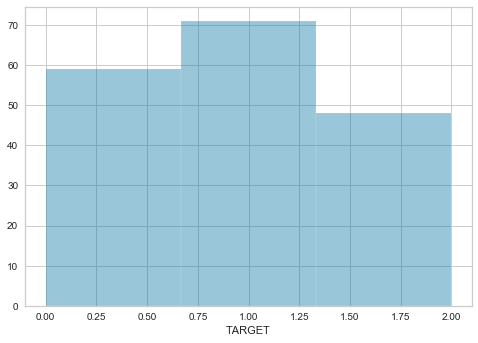

In [4]:

wine_df = pd.DataFrame(wine.data, columns=wine.feature_names)
wine_df['TARGET'] = wine.target
wine_df.head()

wine_df.describe()

wine_df[["TARGET", "alcohol"]].groupby("TARGET").count()

sns.distplot(wine_df["TARGET"],bins=3, kde=False)


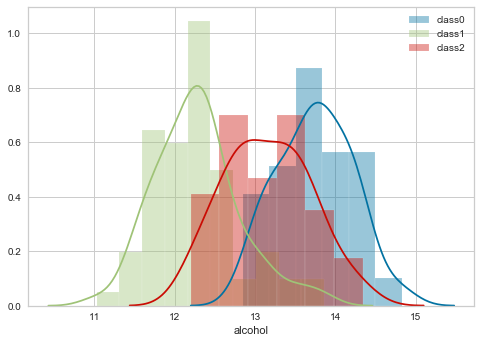

In [5]:
# let's plot the alcohol percentage for each class of wine

for i in wine_df["TARGET"].unique():
    sns.distplot(wine_df["alcohol"][wine_df["TARGET"]==i], label=f'class{i:d}')
plt.legend()


In [6]:
# Kmeans relies in a distance metric, therefore we need to rescale all features to the same scale 

X = wine_df.drop(['TARGET'], axis=1)
y = wine_df['TARGET']

min_max_scaler = preprocessing.MinMaxScaler()  # by default between 0 and 1

x_scaled_fit = min_max_scaler.fit(X)

x_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(x_scaled,columns=X.columns)
X_scaled.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


<Figure size 864x648 with 0 Axes>

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000243300230F0>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

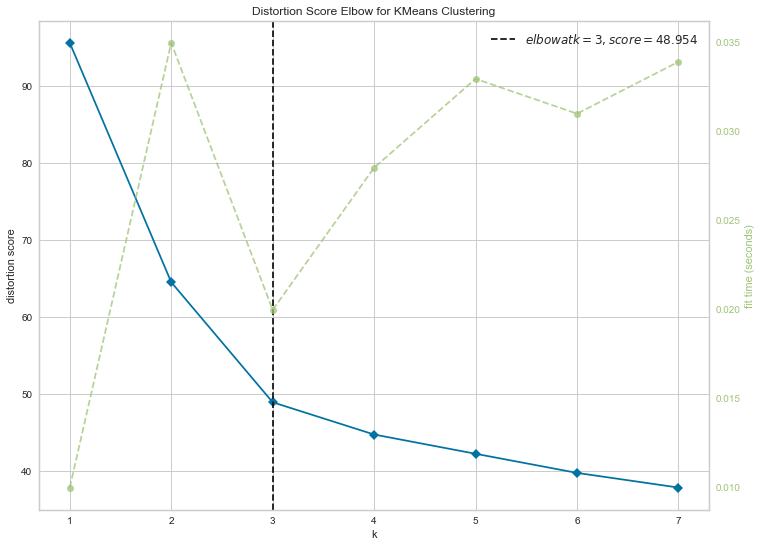

In [7]:
# Elbow method

plt.figure(figsize=(12,9))

# Now we apply KMeans
model = KMeans()

# we want first to find out how many clusters using the elbow technique
visualizer = KElbowVisualizer(model, k=(1,8))
visualizer.fit(X_scaled)       
visualizer.show()


# we know that there are 3 wine types (target=[0,1,2]) 
# and the elbow method correctely chooses 3

<Figure size 864x648 with 0 Axes>

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002433005DDA0>,
                     colors='yellowbrick', is_fitted='auto', model=None)

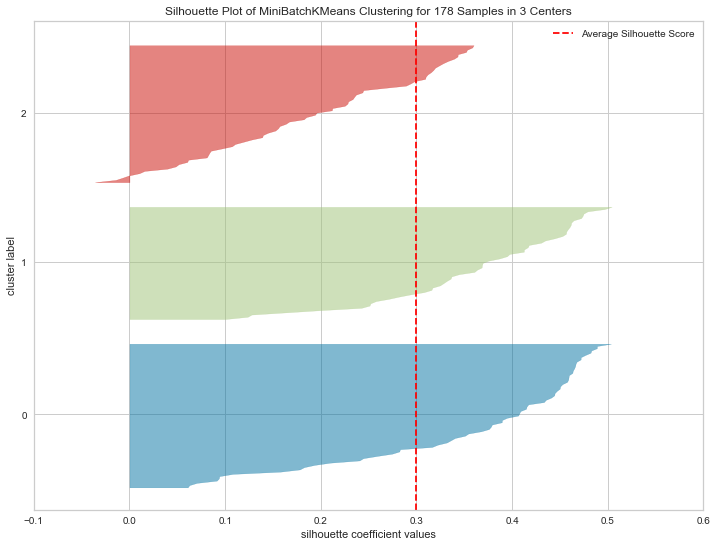

In [8]:
# Now we use Silhoutte to visualize the compactness of the clusters

plt.figure(figsize=(12,9))

#model = KMeans(3)
#model=MiniBatchKMeans(n_clusters=3, verbose=True).fit(X_scaled)

model=MiniBatchKMeans(n_clusters=3).fit(X_scaled)


visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)      
visualizer.show()


<Figure size 864x648 with 0 Axes>

InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000024330560B38>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=10000, model=None, random_state=None,
                     scoring='membership')

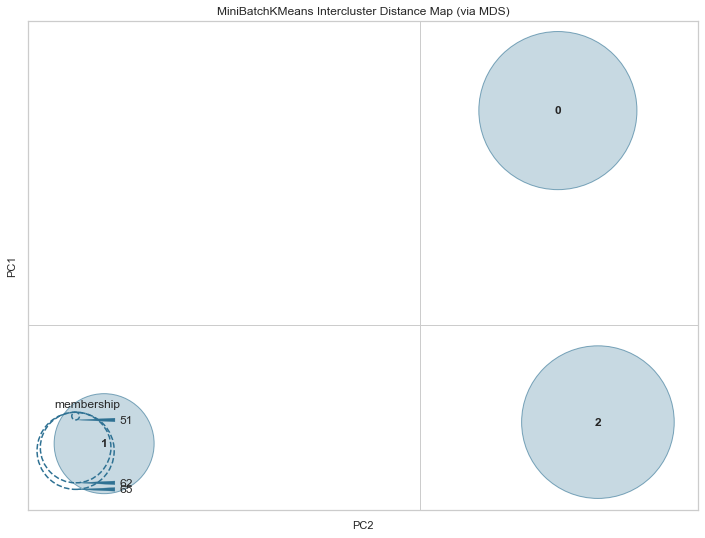

In [9]:
# Inter cluster distance 

plt.figure(figsize=(12,9))

#model=MiniBatchKMeans(n_clusters=3).fit(X_scaled)

visualizer = InterclusterDistance(model, min_size=10000)
#visualizer = InterclusterDistance(model)
visualizer.fit(X_scaled)
visualizer.show()


<Figure size 864x648 with 0 Axes>

C:\Users\Daniel Beck\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LearningCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000024331377198>,
              cv=None, exploit_incremental_learning=False, groups=None,
              model=None, n_jobs=1, pre_dispatch='all', random_state=None,
              scoring='adjusted_rand_score', shuffle=False,
              train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]))

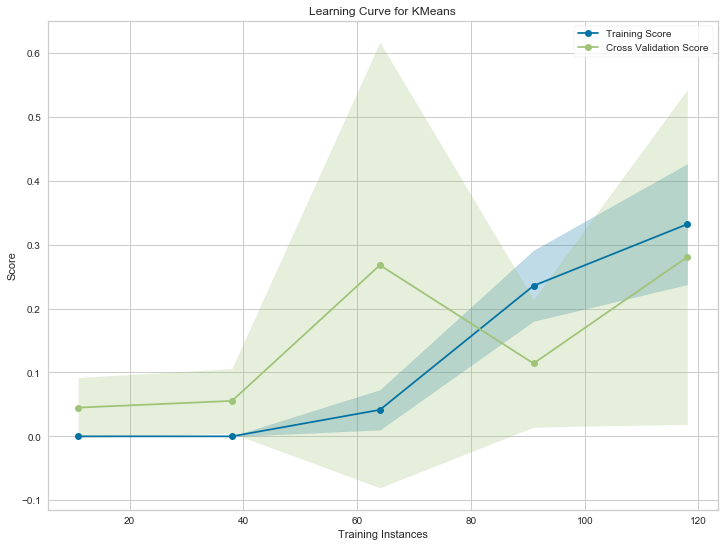

In [10]:
# Learning Curve
plt.figure(figsize=(12,9))

model = KMeans()

visualizer = LearningCurve(model, scoring="adjusted_rand_score")

visualizer.fit(X_scaled, y)        # Fit the data to the visualizer
visualizer.show()                  # Finalize and render the figure

In [11]:
# Can we calculate accuracy ???

#model=KMeans(3)
model=MiniBatchKMeans(n_clusters=3)

model.fit(X_scaled)

print("Predicted labels ----")
print(model.predict(X_scaled))
print()
print("Actual    labels ----")
print(y.values)
print()

print(" ---- Watch the labels ----")

acc_score=accuracy_score(y.values,model.predict(X_scaled))
print(f'Accuracy {acc_score*100:.3f}')


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=3, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Predicted labels ----
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 0 0 0 0 0 0 2 0 2 0 0 1
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

Actual    labels ----
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

 ---- Watch the labels ----
Accuracy 28.090


<h3>Silhouette score</h3>

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). 

The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. 

If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
<p style="margin-left:200px"><b>
    a : mean distance between a sample and all other points in the same class. <br>
    b : mean distance between a sample and all other points in the next nearest cluster.
</b></p>
<br>
<p><b>
$$\large{s=\frac{b-a}{max(a,b}}$$
</b></p>

In [12]:
# Silhouette score

from sklearn import metrics

she=metrics.silhouette_score(X_scaled, model.labels_, metric="euclidean")
print(f'Silhouette score {she:5f}')

Silhouette score 0.300894


In [13]:
#Centroids

model.labels_
model.cluster_centers_

pd.DataFrame(model.cluster_centers_, columns=X.columns)

# BECAUSE WE SCALED WE HAVE TO BRING IT BACK TO THE ORIGINAL RANGES

pd.DataFrame(x_scaled_fit.inverse_transform(model.cluster_centers_),columns=X.columns)

# --- Now with these values we can have an interpretation of what each cluster means ---

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

array([[0.30665222, 0.24184842, 0.47563155, 0.49452086, 0.24940783,
        0.45509727, 0.38256659, 0.41520855, 0.40251755, 0.14714608,
        0.46933995, 0.58812052, 0.15793505],
       [0.71120445, 0.25391203, 0.58898944, 0.35154639, 0.41925864,
        0.64991158, 0.55599643, 0.29465409, 0.47642967, 0.3584821 ,
        0.47750678, 0.69304969, 0.59417865],
       [0.54249687, 0.48167819, 0.56286606, 0.53571429, 0.31259705,
        0.24880439, 0.10461247, 0.62881851, 0.22194213, 0.49103461,
        0.19477594, 0.16293825, 0.25148279]])

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.306652,0.241848,0.475632,0.494521,0.249408,0.455097,0.382567,0.415209,0.402518,0.147146,0.469340,0.588121,0.157935
1,0.711204,0.253912,0.588989,0.351546,0.419259,0.649912,0.555996,0.294654,0.476430,0.358482,0.477507,0.693050,0.594179
2,0.542497,0.481678,0.562866,0.535714,0.312597,0.248804,0.104612,0.628819,0.221942,0.491035,0.194776,0.162938,0.251483


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,12.195278,1.963753,2.249431,20.193705,92.945521,2.299782,2.153366,0.350061,1.685981,3.004552,1.057288,2.875569,499.424939
1,13.732577,2.024795,2.461410,17.420000,108.571795,2.864744,2.975423,0.286167,1.920282,5.481410,1.067333,3.162026,1111.038462
2,13.091488,3.177292,2.412560,20.992857,98.758929,1.701533,0.835863,0.463274,1.113557,7.034926,0.719574,1.714821,630.578869


<h1>Agglomerative Hierarchical Clustering</h1>

Agglomerative hierarchical clustering differs from k-means in a key way. 
Rather than choosing a number of clusters and starting out with random centroids, we instead begin 
with every point in our dataset as a “cluster.” Then we  nd the two closest points and combine them into a cluster. 
Then, we  nd the next closest points, and those become a cluster. 

We repeat the process until we only have one big giant cluster.

<img src="dendrogram.png">

<Figure size 1224x648 with 0 Axes>

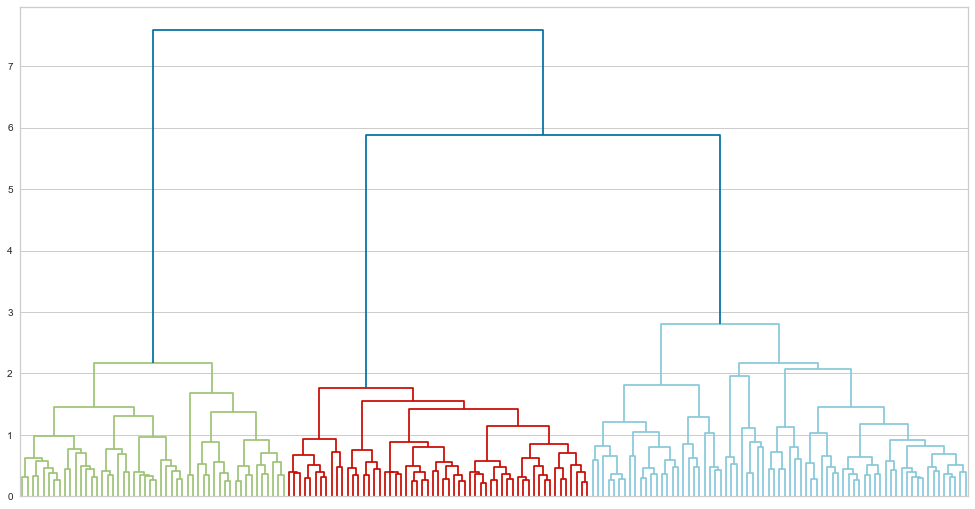

predictions --- 


array([2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

labels --- 


array([2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

pre-assigned labels --- 


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

Accuracy 97.753


In [14]:
 # import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

plt.figure(figsize=(17,9))

# create dendrogram
dn = sch.dendrogram(sch.linkage(X_scaled, method='ward'), no_labels=True)
plt.show()

# create clusters
hc = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')

# save clusters for chart y_hc = hc.fit_predict(points)
print("predictions --- ")
y_hc = hc.fit_predict(X_scaled)
y_hc

print("labels --- ")
hc.labels_

print("pre-assigned labels --- ")
y.values

dk={0:2,1:0,2:1}
acc_score=accuracy_score(list(map(lambda x:dk[x],y.values)),hc.labels_)
print(f'Accuracy {acc_score*100:.3f}')


<b><font color="red" size=6>Mission 1</font>

a) Cluster Europe using the EUindicators dataset and explain the clusterization using the centroids.<br><br>
b) Same for the credit card dataset. 
<br><br>
</b>

In [15]:
headers = ['Country', 'Construction Confidence Indicator',
       'Consumer Confidence Indicator', 'Industrial Confidence Indicator',
       'Retail Confidence Indicator', 'Service Confidence Indicator ',
       'Business Confidence Indicator (avg)', 'TARGET']
EU = pd.read_excel("EUIndicators.xlsx", headers = headers)
EU.head()
print(EU.isna().sum())
EU = EU.dropna()
EU = pd.DataFrame(EU)

,Country,Construction Confidence Indicator,Consumer Confidence Indicator,Industrial Confidence Indicator,Retail Confidence Indicator,Service Confidence Indicator,Business Confidence Indicator (avg)
0,Czech Republic,-19.7,3.5,3.1,19.8,33.1,9.075
1,Germany,-2.2,0.9,1.0,-3.7,18.5,3.400
2,Denmark,-4.3,15.0,-3.9,8.5,8.2,2.125
3,Finland,-4.0,14.9,-3.0,-4.7,11.0,-0.175
4,Luxembourg,5.2,6.7,-15.7,-5.7,NaN,-5.400


 Country                                 0
 Construction Confidence Indicator       1
 Consumer Confidence Indicator           0
 Industrial Confidence Indicator         1
 Retail Confidence Indicator             1
 Service Confidence Indicator            2
 Business Confidence Indicator (avg)     1
dtype: int64


<Figure size 864x648 with 0 Axes>

################### Elbow Method ###################


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000243318636A0>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

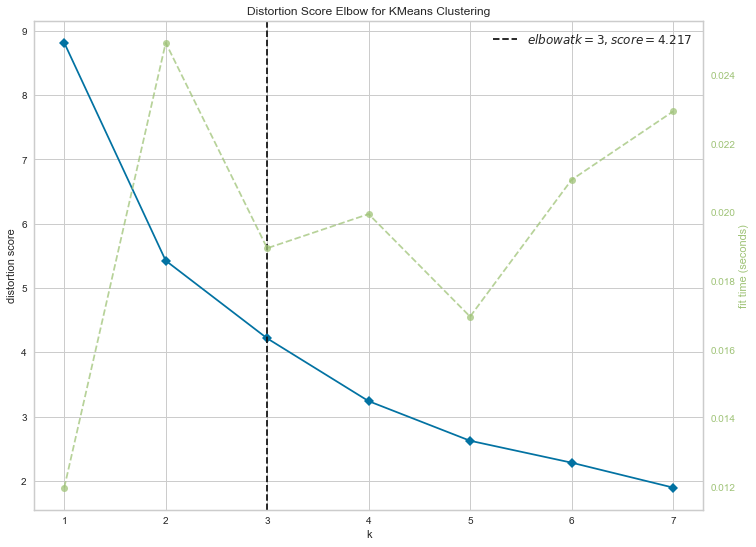

#################################
Elbow method suggests 3 clusters


In [16]:
# Choose EU indicators
X = EU.drop([' Country  '], axis=1)

# Kmeans relies in a distance metric, therefore we need to rescale all features to the same scale 
min_max_scaler = preprocessing.MinMaxScaler()  # by default between 0 and 1
x_scaled_fit = min_max_scaler.fit(X)
x_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(x_scaled,columns=X.columns)

# Elbow method
plt.figure(figsize=(12,9))

#KMeans
model = KMeans()

#Elbow Method
print("################### Elbow Method ###################")
visualizer = KElbowVisualizer(model, k=(1,8))
visualizer.fit(X_scaled)       
visualizer.show()

print("#################################\nElbow method suggests 3 clusters")

################################# Silhouette Method #######################


<Figure size 864x648 with 0 Axes>

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000024331863D30>,
                     colors='yellowbrick', is_fitted='auto', model=None)

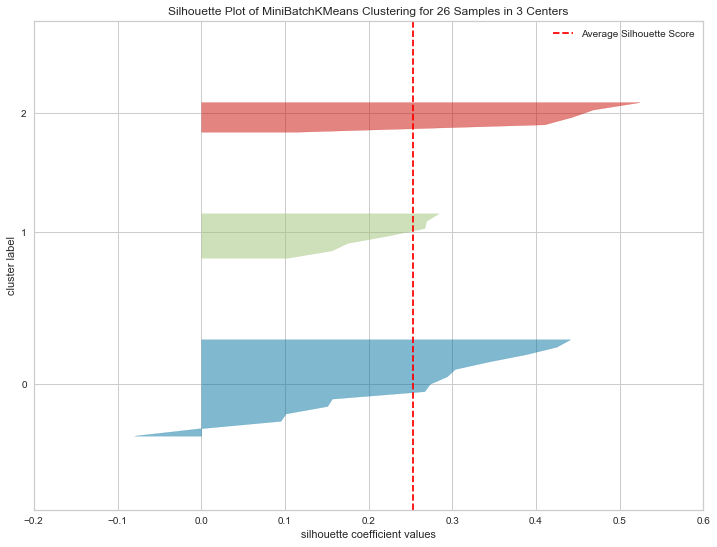

##################################################
Cluster 2 is the most popular, then 0, cluster 1 is almost empty


In [17]:
#Silhoutte to visualize compactness of clusters
print("################################# Silhouette Method #######################")
plt.figure(figsize=(12,9))

model=MiniBatchKMeans(n_clusters=3).fit(X_scaled)

visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)      
visualizer.show()

print("##################################################\nCluster 2 is the most popular, then 0, cluster 1 is almost empty")

################################# Inter Cluster Distance #######################


<Figure size 864x648 with 0 Axes>

InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002433134C208>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=10000, model=None, random_state=None,
                     scoring='membership')

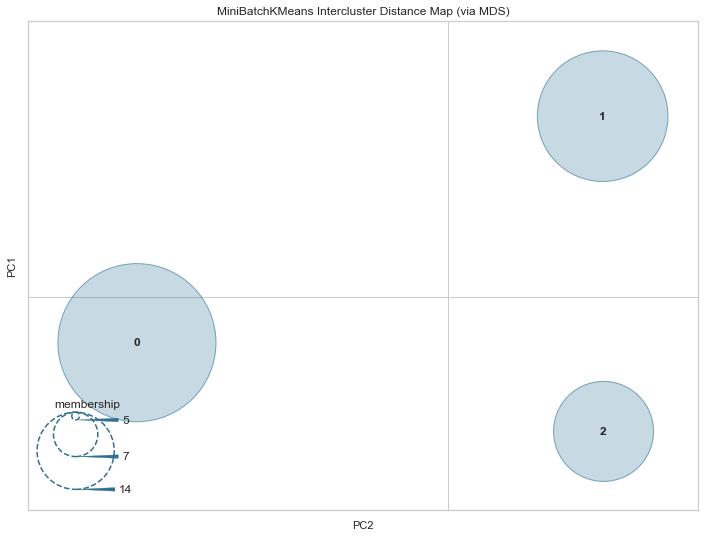

In [18]:
#Inter cluster distance 
print("################################# Inter Cluster Distance #######################")
plt.figure(figsize=(12,9))

visualizer = InterclusterDistance(model, min_size=10000)

#visualizer = InterclusterDistance(model)
visualizer.fit(X_scaled)
visualizer.show()

In [19]:
# Silhouette score
print("###################### Silhouette Score #######################")
from sklearn import metrics

she=metrics.silhouette_score(X_scaled, model.labels_, metric="euclidean")
print(f'Silhouette score {she:5f}')

###################### Silhouette Score #######################
Silhouette score 0.253363


In [20]:
#centroids
print("###################### Centroids #######################")

model.labels_
model.cluster_centers_

pd.DataFrame(model.cluster_centers_, columns=X.columns)

# BECAUSE WE SCALED WE HAVE TO BRING IT BACK TO THE ORIGINAL RANGES
pd.DataFrame(x_scaled_fit.inverse_transform(model.cluster_centers_),columns=X.columns)

# --- Now with these values we can have an interpretation of what each cluster means ---

###################### Centroids #######################


array([0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0])

array([[0.62875985, 0.72459279, 0.78193781, 0.70774097, 0.45755113,
        0.62527723],
       [0.31266746, 0.57535168, 0.36311989, 0.37101776, 0.18010196,
        0.2173407 ],
       [0.57633481, 0.77841977, 0.48482217, 0.0866829 , 0.47844287,
        0.40476564]])

,Construction Confidence Indicator,Consumer Confidence Indicator,Industrial Confidence Indicator,Retail Confidence Indicator,Service Confidence Indicator,Business Confidence Indicator (avg)
0,0.628760,0.724593,0.781938,0.707741,0.457551,0.625277
1,0.312667,0.575352,0.363120,0.371018,0.180102,0.217341
2,0.576335,0.778420,0.484822,0.086683,0.478443,0.404766


,Construction Confidence Indicator,Consumer Confidence Indicator,Industrial Confidence Indicator,Retail Confidence Indicator,Service Confidence Indicator,Business Confidence Indicator (avg)
0,-6.908525,-4.801778,2.614749,11.938232,14.710983,5.588860
1,-26.158552,-15.532214,-4.463274,2.880378,5.305456,-5.608998
2,-10.101210,-0.931619,-2.406505,-4.768230,15.419213,-0.464183


###################### Hierarchical Clustering #######################


<Figure size 1224x648 with 0 Axes>

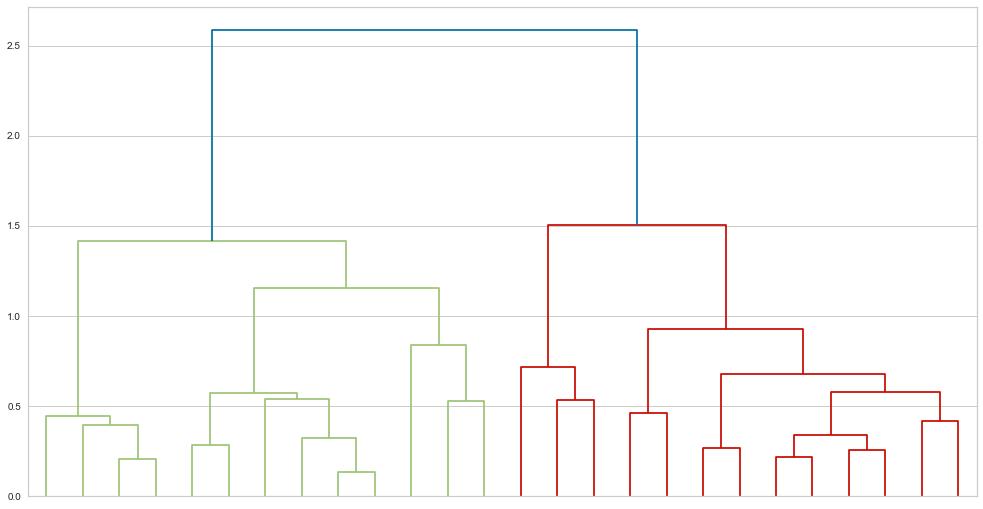

predictions --- 


array([2, 0, 1, 0, 2, 1, 2, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1], dtype=int64)

labels --- 


array([2, 0, 1, 0, 2, 1, 2, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1], dtype=int64)

In [21]:
#import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

print("###################### Hierarchical Clustering #######################")

plt.figure(figsize=(17,9))

# create dendrogram
dn = sch.dendrogram(sch.linkage(X_scaled, method='ward'), no_labels=True)
plt.show()

# create clusters
hc = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')

# save clusters for chart y_hc = hc.fit_predict(points)
print("predictions --- ")
y_hc = hc.fit_predict(X_scaled)
y_hc

print("labels --- ")
hc.labels_

In [22]:
# print Clusters
EU['cluster'] = hc.labels_
one = EU['cluster'] == 1
two = EU['cluster'] == 2
zero = EU['cluster'] == 0
EU[one]
EU[two]
EU[zero]

,Country,Construction Confidence Indicator,Consumer Confidence Indicator,Industrial Confidence Indicator,Retail Confidence Indicator,Service Confidence Indicator,Business Confidence Indicator (avg),cluster
2,Denmark,-4.3,15.0,-3.9,8.5,8.2,2.125,1
6,Netherlands,10.7,8.1,1.6,6.9,8.8,7.000,1
11,Bulgaria,-21.7,-28.7,0.6,15.3,9.8,1.000,1
13,Estonia,-3.0,-3.5,2.6,12.5,5.8,4.475,1
17,Croatia,-11.2,-19.3,4.4,8.0,15.9,4.275,1
18,Hungary,-5.1,-17.0,5.7,9.1,7.1,4.200,1
24,Romania,-13.3,-19.1,0.4,10.5,8.1,1.425,1
25,Slovenia,-7.0,-11.2,6.3,16.7,19.3,8.825,1
26,Slovakia,-10.0,-7.5,4.7,15.7,7.3,4.425,1
27,United Kingdom,-4.5,-0.3,4.4,7.4,7.8,3.775,1


,Country,Construction Confidence Indicator,Consumer Confidence Indicator,Industrial Confidence Indicator,Retail Confidence Indicator,Service Confidence Indicator,Business Confidence Indicator (avg),cluster
0,Czech Republic,-19.7,3.5,3.1,19.8,33.1,9.075,2
5,Malta,4.4,2.3,4.7,6.1,28.4,10.900,2
7,Sweden,15.7,13.8,3.7,17.7,26.4,15.875,2


,Country,Construction Confidence Indicator,Consumer Confidence Indicator,Industrial Confidence Indicator,Retail Confidence Indicator,Service Confidence Indicator,Business Confidence Indicator (avg),cluster
1,Germany,-2.2,0.9,1.0,-3.7,18.5,3.400,0
3,Finland,-4.0,14.9,-3.0,-4.7,11.0,-0.175,0
9,Austria,-3.7,-8.1,-3.5,-7.1,15.2,0.225,0
10,Belgium,-13.9,-4.0,-4.3,-7.0,15.2,-2.500,0
12,Cyprus,-28.4,-9.1,-1.8,-0.9,18.0,-3.275,0
14,Greece,-45.2,-56.9,-6.3,2.1,3.1,-11.575,0
15,Spain,-28.4,-1.9,-1.6,11.3,18.5,-0.050,0
16,France,-29.2,-14.2,-3.4,-4.4,-0.8,-9.450,0
19,Italy,-19.8,-9.2,-1.3,6.4,7.9,-1.700,0
20,Lithuania,-19.7,-8.8,-6.4,5.5,9.6,-2.750,0


In [23]:
print("#####################################################################################")
print("#####################################################################################")
print("########################### Credit Cards Data Set ###################################")
print("#####################################################################################")
print("#####################################################################################")

filename="CCData.csv"
CC = pd.read_csv(filename)

#Drop NaN
CC = CC.dropna()

# Choose indicators
X = CC.drop(['CUST_ID'], axis=1)

#####################################################################################
#####################################################################################
########################### Credit Cards Data Set ###################################
#####################################################################################
#####################################################################################


In [24]:
print("############################ K Means ################################")

# Kmeans relies in a distance metric, therefore we need to rescale all features to the same scale 
min_max_scaler = preprocessing.MinMaxScaler()  # by default between 0 and 1
x_scaled_fit = min_max_scaler.fit(X)
x_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(x_scaled,columns=X.columns)

############################ K Means ################################


<Figure size 864x648 with 0 Axes>

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000243331F3160>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

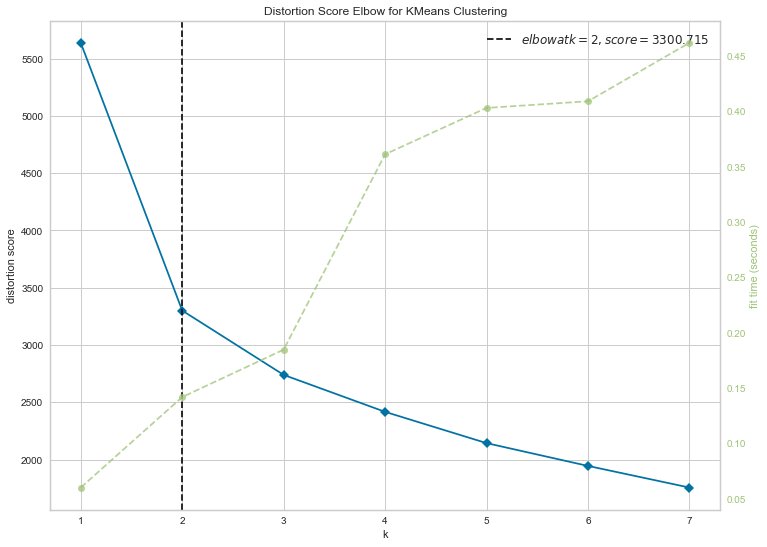

In [25]:
#Elbow method
plt.figure(figsize=(12,9))

#Now we apply KMeans
model = KMeans()

#we want first to find out how many clusters using the elbow technique
visualizer = KElbowVisualizer(model, k=(1,8))
visualizer.fit(X_scaled)       
visualizer.show()

#Elbow method suggests 2 clusters

################################# Silhouette Method #######################


<Figure size 864x648 with 0 Axes>

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000243331CA4A8>,
                     colors='yellowbrick', is_fitted='auto', model=None)

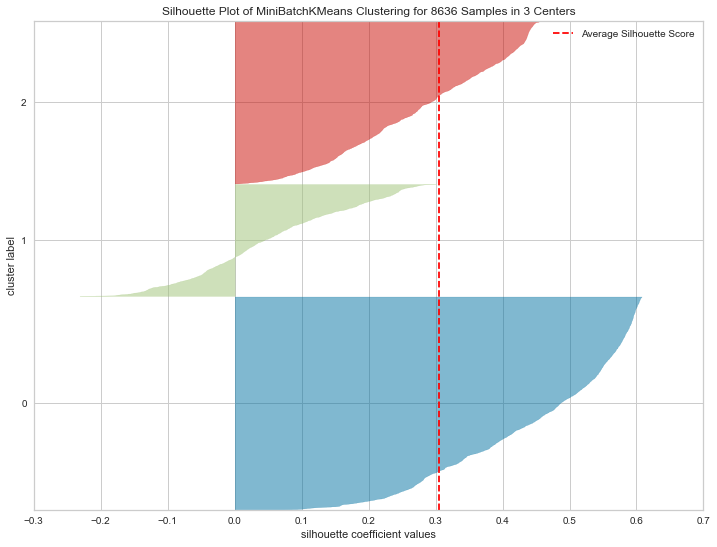

##################################################
Cluster 1 is the most popular, then 0, cluster 2 is almost empty


In [26]:
#Silhoutte to visualize compactness of clusters
print("################################# Silhouette Method #######################")
plt.figure(figsize=(12,9))

model=MiniBatchKMeans(n_clusters=3).fit(X_scaled)

visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)      
visualizer.show()

print("##################################################\nCluster 1 is the most popular, then 0, cluster 2 is almost empty")

<Figure size 864x648 with 0 Axes>

InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000243337490B8>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=10000, model=None, random_state=None,
                     scoring='membership')

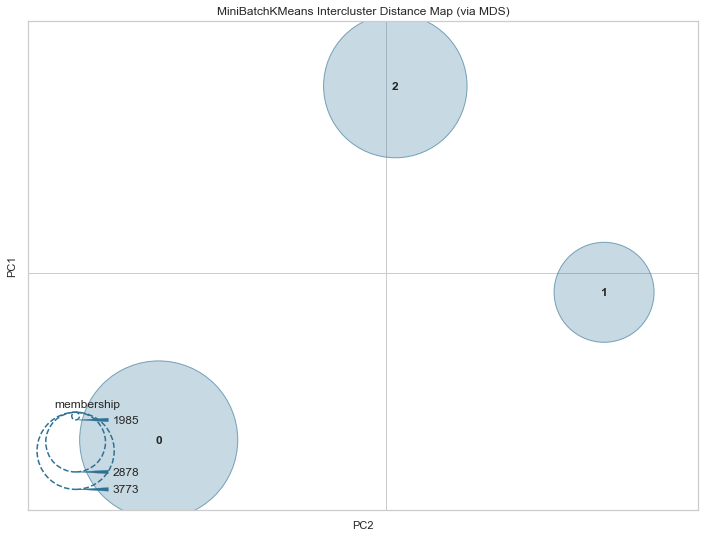

In [27]:
# Inter cluster distance 

plt.figure(figsize=(12,9))

visualizer = InterclusterDistance(model, min_size=10000)
#visualizer = InterclusterDistance(model)
visualizer.fit(X_scaled)
visualizer.show()

In [28]:
# Silhouette score

from sklearn import metrics

she=metrics.silhouette_score(X_scaled, model.labels_, metric="euclidean")
print(f'Silhouette score {she:5f}')

Silhouette score 0.304551


In [29]:
# Centroids

model.labels_
model.cluster_centers_

pd.DataFrame(model.cluster_centers_, columns=X.columns)

# BECAUSE WE SCALED WE HAVE TO BRING IT BACK TO THE ORIGINAL RANGES

pd.DataFrame(x_scaled_fit.inverse_transform(model.cluster_centers_),columns=X.columns)

# --- Now with these values we can have an interpretation of what each cluster means ---

array([0, 0, 1, ..., 2, 0, 1])

array([[0.10228687, 0.8771374 , 0.00431159, 0.00449651, 0.00125471,
        0.03234034, 0.08759834, 0.05492055, 0.03053836, 0.14213253,
        0.04175066, 0.00437078, 0.13700788, 0.03056813, 0.01226909,
        0.03636476, 0.91597796],
       [0.05757198, 0.83928376, 0.02610566, 0.02484904, 0.01191098,
        0.01140171, 0.60848883, 0.3853499 , 0.26136294, 0.05131639,
        0.01501844, 0.04058095, 0.16403312, 0.03329334, 0.00742431,
        0.26770962, 0.92890059],
       [0.07333055, 0.95965136, 0.03726382, 0.02041111, 0.04425587,
        0.01218764, 0.93971585, 0.26667038, 0.88092596, 0.04830826,
        0.01564246, 0.08866292, 0.15725341, 0.04127037, 0.0127524 ,
        0.25453392, 0.92680427]])

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.102287,0.877137,0.004312,0.004497,0.001255,0.032340,0.087598,0.054921,0.030538,0.142133,0.041751,0.004371,0.137008,0.030568,0.012269,0.036365,0.915978
1,0.057572,0.839284,0.026106,0.024849,0.011911,0.011402,0.608489,0.385350,0.261363,0.051316,0.015018,0.040581,0.164033,0.033293,0.007424,0.267710,0.928901
2,0.073331,0.959651,0.037264,0.020411,0.044256,0.012188,0.939716,0.266670,0.880926,0.048308,0.015642,0.088663,0.157253,0.041270,0.012752,0.254534,0.926804


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,1947.862944,0.877137,211.438564,183.283444,28.230954,1524.433529,0.087598,0.054921,0.030538,0.213199,5.135331,1.564738,4153.386134,1550.508866,937.453911,0.036365,11.495868
1,1096.351246,0.839284,1280.210533,1012.878097,267.997051,537.444762,0.608489,0.385350,0.261363,0.076975,1.847268,14.527979,4962.792042,1688.735443,567.282550,0.267710,11.573404
2,1396.443761,0.959651,1827.401572,831.982512,995.756992,574.491247,0.939716,0.266670,0.880926,0.072462,1.924023,31.741326,4759.739689,2093.341817,974.381228,0.254534,11.560826


<Figure size 1224x648 with 0 Axes>

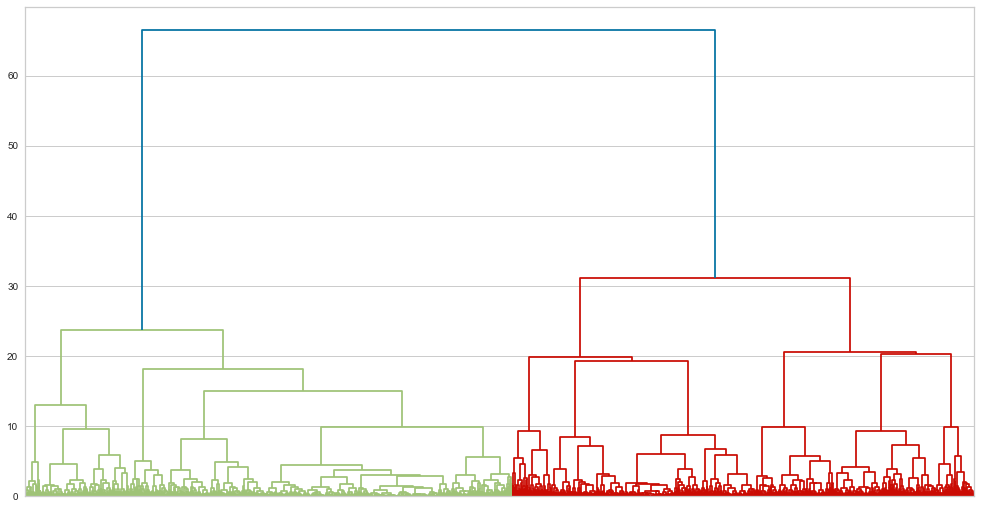

predictions --- 


array([0, 0, 1, ..., 2, 0, 2], dtype=int64)

labels --- 


array([0, 0, 1, ..., 2, 0, 2], dtype=int64)

In [30]:
 # import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

plt.figure(figsize=(17,9))

# create dendrogram
dn = sch.dendrogram(sch.linkage(X_scaled, method='ward'), no_labels=True)
plt.show()

# create clusters
hc = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')

# save clusters for chart y_hc = hc.fit_predict(points)
print("predictions --- ")
y_hc = hc.fit_predict(X_scaled)
y_hc

print("labels --- ")
hc.labels_

In [31]:
print("#####################################################################################")
print("#####################################################################################")
print("############################## END OF EXERCISE ######################################")
print("#####################################################################################")
print("#####################################################################################")

#####################################################################################
#####################################################################################
############################## END OF EXERCISE ######################################
#####################################################################################
#####################################################################################
